In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_feature(booster,figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [2]:
items = pd.read_csv("input/items.csv")
shops = pd.read_csv("input/shops.csv")
cats = pd.read_csv("input/item_categories.csv")
train = pd.read_csv("input/sales_train.csv")
test = pd.read_csv("input/test.csv").set_index("ID")

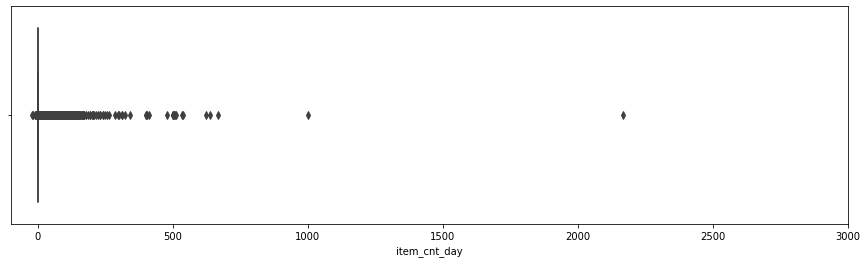

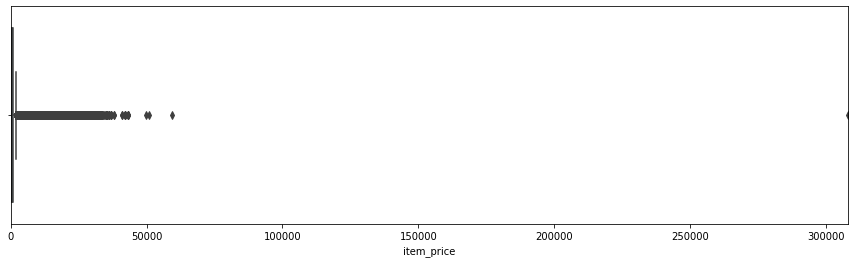

In [3]:
#購入回数の異常値検出
plt.figure(figsize=(15,4))
plt.xlim(-100,3000)
sns.boxplot(x=train["item_cnt_day"])

#商品価格の異常値検出
plt.figure(figsize=(15,4))
plt.xlim(train["item_price"].min(),train["item_price"].max())
sns.boxplot(x=train["item_price"])

In [4]:
#外れ値については学習データに含まない
train = train[train["item_price"]<10000]
train = train[train["item_cnt_day"]<1001]

In [5]:
#価格マイナスデータを補正する
#train_minus = train[train["item_price"] < 0]
#train_minus
median = train[(train["date_block_num"]==4)&(train["shop_id"]==32)&(train["item_id"]==2973)&(train["item_price"]>0)]["item_price"].median()
train[train["item_price"]<0] = median

In [6]:
#rename shop_id
train["shop_id"].loc[train["shop_id"]==0] = 57
test["shop_id"].loc[test["shop_id"]==0] = 57
train["shop_id"].loc[train["shop_id"]==1] = 58
test["shop_id"].loc[test["shop_id"]==1] = 58
train["shop_id"].loc[train["shop_id"]==10] = 11
test["shop_id"].loc[test["shop_id"]==10] = 11

/Users/hayashiryuutarou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
#City Codeの作成
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
shops["city"].loc[shops["city"] == "!Якутск"] = 'Якутск'
shops["city_code"] = LabelEncoder().fit_transform(shops["city"])
shops = shops[["shop_id","city_code"]]

In [8]:
#Category Type Code & Sub Type Codeの作成
cats["split"] = cats["item_category_name"].str.split("-")
cats["type"] = cats["split"].map(lambda x: x[0].strip())
cats["type_code"] = LabelEncoder().fit_transform(cats["type"])
cats["subtype"] = cats["split"].map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform(cats["subtype"])
cats = cats[["item_category_id","type_code","subtype_code"]]

In [9]:
#itemsから不要な情報削除
items.drop(["item_name"],axis=1,inplace=True)

In [10]:
ts = time.time()
matrix = []
cols = ["date_block_num","shop_id","item_id"]
for i in range(34):
    sales = train[train["date_block_num"] == i]
    matrix.append(np.array(list(product([i],sales["shop_id"].unique(),sales["item_id"].unique())),dtype="int16"))
matrix = pd.DataFrame(np.vstack(matrix),columns=cols)
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time()-ts

9.254701137542725

In [11]:
train["revenue"] = train["item_price"] * train["item_cnt_day"]

In [12]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

/Users/hayashiryuutarou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1108: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


5.448116064071655

In [13]:
#Create Test set
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test["shop_id"].astype(np.int8)
test["item_id"] = test["item_id"].astype(np.int16)

In [14]:
ts = time.time()
matrix = pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)
matrix.fillna(0,inplace=True)
time.time() -ts

0.09053301811218262

In [15]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.06772518157959

In [23]:
#Create Lag Data Function
def lag_feature_cnt(df,target_cols,lags,col):
    #特徴量グループ
    group = df.groupby(target_cols).agg({"item_cnt_month":["mean"]})
    group.columns = [col]
    group.reset_index(inplace=True)
    #特徴量のマージ
    df = pd.merge(df,group,on=target_cols,how="left")
    df[col] = df[col].astype(np.float16)
    
    #ラグ特徴量の作成
    tmp = df[["date_block_num","shop_id","item_id",col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ["date_block_num","shop_id","item_id",col+"_lag_"+str(i)]
        shifted["date_block_num"] += i
        df = pd.merge(df,shifted, on =["date_block_num","shop_id","item_id"],how="left")
    df.drop([col],axis=1,inplace=True)
    return df

In [17]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
#Lag Data
ts = time.time()
matrix = lag_feature(matrix,[1,2,3,6,12],"item_cnt_month")
time.time() - ts

24.48663592338562

In [24]:
#何ヶ月目かとitem_idでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num"],[1],"date_avg_item_cnt")
#何ヶ月目かとitem_idでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","item_id"],[1,2,3,6,12],"date_item_avg_item_cnt")
#何ヶ月目かとshop_idでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","shop_id"],[1,2,3,6,12],"date_shop_avg_item_cnt")
#何ヶ月目かとitem_category_idでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","item_category_id"],[1],"date_cat_avg_item_cnt")
#何ヶ月目かとshop_idとitem_category_idでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","shop_id","item_category_id"],[1],"date_shop_cat_avg_item_cnt")
#何ヶ月目かとshop_idとtype_codeでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","shop_id","type_code"],[1],"date_shop_type_avg_item_cnt")
#何ヶ月目かとshop_idとsubtype_codeでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","shop_id","subtype_code"],[1],"date_shop_subtype_avg_item_cnt")
#何ヶ月目かとcity_codeでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","city_code"],[1],"date_city_avg_item_cnt")
#何ヶ月目かとitem_idとcity_codeでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","item_id","city_code"],[1],"date_item_city_avg_item_cnt")
#何ヶ月目かとtype_codeでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","type_code"],[1],"date_type_avg_item_cnt")
#何ヶ月目かとsubtype_codeでgroupbyしたラグ特徴量
matrix = lag_feature_cnt(matrix,["date_block_num","subtype_code"],[1],"date_subtype_avg_item_cnt")

In [25]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

294.5325839519501

In [26]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

16.86177682876587

In [28]:
#Create Special features
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [31]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

In [32]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num  

In [33]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [36]:
matrix = matrix[matrix["date_block_num"] > 11]

In [37]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

/Users/hayashiryuutarou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [38]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4471849,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.407471,0.086975,0.044434,0.130493,0.065247,0.155518,0.144043,0.097534,0.088013,0.094788,0.139893,1.082031,0.955566,0.808594,0.915527,0.144043,0.0,1.034180,1.059570,-0.282715,0.514160,0,31,1,1,12,12
4471850,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.407471,1.021484,1.022461,0.521973,0.891113,0.000000,0.144043,0.097534,0.088013,0.094788,0.000000,0.291504,0.046234,0.051727,0.046234,0.144043,0.0,0.270020,0.291504,-0.483398,0.514160,0,31,1,1,11,11
4471851,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.407471,0.543457,0.600098,0.543457,0.304443,0.000000,0.144043,0.097534,0.088013,0.094788,0.000000,0.232788,0.059448,0.051727,0.064697,0.144043,0.0,0.270020,0.234009,-0.137451,0.514160,0,31,1,1,11,11
4471852,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.407471,1.934570,1.799805,1.260742,1.891602,5.378906,0.144043,0.097534,0.088013,0.094788,0.139893,0.291504,0.046234,0.051727,0.046234,0.144043,0.0,0.270020,0.291504,-0.407227,0.514160,0,31,-1,1,12,12
4471853,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0,0.407471,0.913086,0.333252,0.717285,1.000000,1.355469,0.144043,0.097534,0.088013,0.094788,0.139893,0.232788,0.059448,0.051727,0.064697,0.144043,1.0,0.270020,0.234009,-0.225464,0.514160,0,31,1,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084746,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.258545,0.045441,0.023254,0.071411,0.590820,0.000000,0.126953,0.128784,0.139160,0.137817,0.000000,0.196899,0.126831,0.089355,0.126831,0.135864,0.5,0.147095,0.196899,-0.475098,-0.222168,10,30,1,-1,11,11
11084747,34,45,16188,0.0,20,64,14,42,0.0,0.0,0.0,0.0,0.0,0.258545,0.022720,0.069763,0.000000,0.000000,0.000000,0.126953,0.128784,0.000000,0.000000,0.000000,0.155884,0.094482,0.106445,0.094482,0.135864,0.0,0.237793,0.155884,0.081116,-0.222168,10,30,-1,-1,2,2
11084748,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.258545,0.113647,0.069763,0.095215,0.250000,0.180054,0.126953,0.128784,0.139160,0.137817,0.180298,0.196899,0.126831,0.089355,0.126831,0.135864,0.0,0.147095,0.196899,0.155884,-0.222168,10,30,1,-1,34,34
11084749,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.258545,0.045441,0.069763,0.166626,0.090881,0.000000,0.126953,0.128784,0.139160,0.137817,0.000000,0.220825,0.083740,0.097046,0.083740,0.135864,0.0,0.224243,0.220825,-0.091736,-0.222168,10,30,-1,-1,11,11


In [39]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train

In [40]:
data = pd.read_pickle('data.pkl')

In [43]:
data = data[[
    "date_block_num",
    "shop_id",
    "item_id",
    "item_cnt_month",
    "city_code",
    "item_category_id",
    "type_code",
    "subtype_code",
    "item_cnt_month_lag_1",
    "item_cnt_month_lag_2",
    "item_cnt_month_lag_3",
    "item_cnt_month_lag_6",
    "item_cnt_month_lag_12",
    "date_avg_item_cnt_lag_1",
    "date_item_avg_item_cnt_lag_1",
    "date_item_avg_item_cnt_lag_2",
    "date_item_avg_item_cnt_lag_3",
    "date_item_avg_item_cnt_lag_6",
    "date_item_avg_item_cnt_lag_12",
    "date_shop_avg_item_cnt_lag_1",
    "date_shop_avg_item_cnt_lag_2",
    "date_shop_avg_item_cnt_lag_3",
    "date_shop_avg_item_cnt_lag_6",
    "date_shop_avg_item_cnt_lag_12",
    "date_cat_avg_item_cnt_lag_1",
    "date_shop_cat_avg_item_cnt_lag_1",
    "date_city_avg_item_cnt_lag_1",
    "date_item_city_avg_item_cnt_lag_1",
    "delta_price_lag",
    "month",
    "days",
    "item_shop_last_sale",
    "item_last_sale",
    "item_shop_first_sale",
    "item_first_sale"
]]

In [44]:
X_train = data[data["date_block_num"] < 33].drop(["item_cnt_month"],axis=1)
Y_train = data[data["date_block_num"] < 33]["item_cnt_month"]
X_valid = data[data["date_block_num"] == 33].drop(["item_cnt_month"],axis=1)
Y_valid = data[data["date_block_num"] == 33]["item_cnt_month"]
X_test = data[data["date_block_num"] ==34].drop(["item_cnt_month"],axis=1)

In [ ]:
model = XGBRegressor(
    max_depth = 8,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.3,
    seed=42
)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train,Y_train),(X_valid,Y_valid)],
    verbose=True,
    early_stopping_rounds = 10
)

[12:56:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:53] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12626	validation_1-rmse:1.1243
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.0854	validation_1-rmse:1.08934
[2]	validation_0-rmse:1.05258	validation_1-rmse:1.05785
[3]	validation_0-rmse:1.00906	validation_1-rmse:1.03003
[4]	validation_0-rmse:0.980089	validation_1-rmse:1.00696
[5]	validation_0-rmse:0.959772	validation_1-rmse:0.99088
[6]	validation_0-rmse:0.94157	validation_1-rmse:0.97544
[7]	validation_0-rmse:0.920123	validation_1-rmse:0.962994


In [ ]:
Y_pred = model.predict(X_valid).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)

submission = pd.DataFrame({
    "ID":test.index,
    "item_cnt_month":Y_test
})
submission.to_csv("xgb_submission.csv",index=False)

In [ ]:
plot_features(model,(15,10)